# LABORATORIUM 9: Zastosowania DFT

## Zadanie 2: OCR

Autor: Dariusz Marecik

Celem projektu jest stworzenie OCR oparte o dyskretne przekształcenia Fouriera (DFT)

## Czytanie bibliotek i zdefiniowanie alfabetu
Na początku projektu zaimportowałem niezbędne biblioteki do przetwarzania obrazów i danych numerycznych, m.in. PIL, NumPy oraz OpenCV. Zdefiniowałem również ciąg znaków ALFABET, który zawiera wszystkie wielkie i małe litery alfabetu łacińskiego, cyfry oraz część znaków przystankowych:

In [2]:
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageChops
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

ALFABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789!%()+,-;_.'"

Zgodnie z założeniami projektu, wymagane było wsparcie wyłącznie dla małych liter alfabetu oraz wybranych znaków interpunkcyjnych (., ,, ?, !). Zdecydowałem się jednak rozszerzyć obsługiwany zestaw znaków do pełnego alfabetu oraz dodatkowych symboli. Dzięki temu system może być potencjalnie wykorzystany w szerszym zakresie zastosowań, np. do rozpoznawania tekstu zawierającego wielkie litery lub liczby.

## Funkcja porównująca teksty – odległość Levenshteina
Do oceny jakości działania systemu OCR wykorzystałem funkcję levenshtein_distance, która oblicza tzw. odległość Levenshteina między dwoma ciągami znaków. Jest to klasyczna miara podobieństwa tekstów, określająca minimalną liczbę operacji (wstawień, usunięć lub zamian znaków), które są potrzebne, aby przekształcić jeden ciąg w drugi.

In [3]:
def levenshtein_distance(s1, s2):
    n, m = len(s1), len(s2)
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        dp[i][0] = i 
    for j in range(m + 1):
        dp[0][j] = j  

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if s1[i - 1] == s2[j - 1]:
                cost = 0 
            else:
                cost = 1 

            dp[i][j] = min(
                dp[i - 1][j] + 1,      # usunięcie (delete)
                dp[i][j - 1] + 1,      # wstawienie (insert)
                dp[i - 1][j - 1] + cost  # zamiana (substitute)
            )
    return dp[n][m]

### Obliczanie dokładności rozpoznania tekstu

Funkcja `calc_acc` oblicza dokładność rozpoznania tekstu, porównując linie tekstu wykrytego z wzorcowym i wykorzystując odległość Levenshteina do zliczenia błędów. Wynik to stosunek poprawnych znaków do wszystkich znaków.


In [4]:
def calc_acc(text_detexted, modal_text):
    all_chars = 0
    mistakes = 0
    for i in range(len(text_detexted)):
        all_chars += len(modal_text[i])
        mistakes += levenshtein_distance(text_detexted[i], modal_text[i])
    return 1 - mistakes/all_chars

# Funkcje wczytywania obrazów i tekstów

### Wczytywanie obrazu

Funkcja `load_image` służy do wczytywania obrazu z pliku o podanej nazwie (domyślnie `"cos.png"`). Obraz jest konwertowany do skali szarości (`"L"`), co upraszcza dalsze przetwarzanie w systemie OCR.


In [5]:
def load_image(name = "cos.png"):
    img = Image.open(name).convert("L")
    return img

### Wczytywanie wzorców liter

Funkcja `load_alfabet` wczytuje wzorce liter zapisane jako obrazy w folderze `letters/<font_name>/`. Dla każdego znaku z wcześniej zdefiniowanego alfabetu `ALFABET` otwierany jest odpowiadający mu plik PNG, konwertowany do skali szarości, a następnie binarizowany (piksele ciemne są interpretowane jako czarne). Wynikiem działania funkcji jest słownik mapujący każdy znak na jego binarną reprezentację w postaci macierzy `numpy`. Wzorce te są później wykorzystywane w procesie dopasowywania znaków (OCR).


In [25]:
def load_alfabet(font_name):
    alfabet_dict = {}
    for char in ALFABET:
        img = Image.open(f"letters/{font_name}/{char}.png").convert("L")
        alfabet_dict[char] = np.array(img) < 128  # zlicza czarne
    return alfabet_dict

### Wczytywanie tekstu referencyjnego

Funkcja `read_model_text` wczytuje tekst referencyjny z pliku `.txt` o podanej nazwie (z folderu `text_images/`). Zwraca listę niepustych, oczyszczonych z białych znaków linii tekstu, która służy do porównania z wynikiem działania OCR.


In [7]:
def read_model_text(name):
    path = f"text_images/{name}.txt"
    model_text = []
    with open(path, "r", encoding="utf-8") as file:
        lines = [line.strip() for line in file]  # usuwa spacje i \n
        # filtrujemy puste linie
        lines = [line for line in lines if line != ""]
        model_text.extend(lines)  # dodajemy linie do listy model_text
    return model_text

# Funkcje do preprocesowania obrazów


### Dodawanie marginesu do obrazu

Funkcja `add_margin` dodaje margines o zadanej szerokości (domyślnie 100 pikseli) dookoła obrazu. Obraz zostaje wklejony na białe tło większego rozmiaru, co ułatwia dalsze przetwarzanie.


In [8]:
def add_margin(image, margin = 100):
    """Przytnij tylko lewe i prawe marginesy — wysokość pozostaje bez zmian"""
    new_width = image.size[0] + 2 * margin
    new_height = image.size[1] + 2 * margin
    new_image = Image.new(image.mode, (new_width, new_height), 255)
    new_image.paste(image, (margin, margin))
    return new_image

### Usuwanie marginesów z obrazu

Funkcja `crop_all` usuwa jednolite marginesy (domyślnie białe) z lewej i prawej strony obrazu, zachowując jego pełną wysokość. Wykorzystuje różnicę względem tła, aby wykryć rzeczywisty obszar zawierający treść.


In [9]:
def crop_all(image, background=255):
    """Przytnij tylko lewe i prawe marginesy — wysokość pozostaje bez zmian"""
    bg = Image.new(image.mode, image.size, background)
    diff = ImageChops.difference(image, bg)
    bbox = diff.getbbox()
    
    if bbox:
        return image.crop(bbox)  # zachowujemy pełną wysokość
    else:
        return image  # pusty obraz

### Usuwanie szumów z obrazu

Funkcja `denoise_image` stosuje algorytm `fastNlMeansDenoising` z biblioteki OpenCV, który redukuje szumy w obrazie przy zachowaniu detali. Parametry zostały dobrane tak, by skutecznie wygładzić obraz przed dalszym przetwarzaniem OCR.


In [10]:
def denoise_image(image):
    return cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)

### Korekcja pochylenia obrazu (deskew) metodą Hougha

Funkcja `deskew_pil_hough_version` służy do automatycznego wykrywania i korekcji pochylenia (obracania) obrazu tekstowego, co jest istotne dla poprawnego rozpoznawania znaków w OCR.

Proces działania funkcji:

1. **Konwersja obrazu** — wejściowy obraz w formacie PIL jest konwertowany do macierzy NumPy w skali szarości.

2. **Detekcja krawędzi** — za pomocą operatora Canny wykrywane są krawędzie na obrazie.

3. **Wykrywanie linii** — metoda Hougha znajduje linie w obrazie krawędziowym, co pozwala określić orientację tekstu.

4. **Obliczenie kąta obrotu** — na podstawie wykrytych linii wyliczany jest średni kąt odchylenia od poziomu.

5. **Obrót obrazu** — obraz jest obracany o ujemny średni kąt, by wyrównać tekst do poziomu. Przy tym obliczany jest nowy rozmiar obrazu, aby uniknąć ucinania liter po rotacji.

6. **Przycinanie marginesów** — po obrocie usuwa się puste, jednolite obszary wokół tekstu.

7. **Dodanie marginesu** — wokół tekstu dodawany jest biały margines, aby DFT lepiej sobie radził z przetwarzaniem obrazu.

8. **Redukcja szumów** — zastosowanie filtra denoisingowego poprawia jakość obrazu.

9. **Zwrócenie wyniku** — finalny obraz zwracany jest w formacie PIL.

Dzięki tej procedurze tekst na obrazach jest wyrównany poziomo, co znacząco poprawia efektywność i dokładność dalszego rozpoznawania znaków.


In [33]:
def deskew_pil_hough_version(pil_image, margin=10):
    # Konwersja PIL.Image → NumPy (grayscale)
    gray = np.array(pil_image.convert("L"))
    gray = denoise_image(gray)

    # Wykrywanie krawędzi
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Wyszukiwanie linii za pomocą HoughLines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    angles = []
    if lines is not None:
        for rho, theta in lines[:, 0]:
            angle = theta - np.pi / 2
            angles.append(angle)

    # Jeśli wykryto linie, bierzemy średni kąt, inaczej kąt 0
    mean_angle = np.mean(angles) if angles else 0

    # Obrót obrazu (uwaga: angle w stopniach)
    angle_deg = mean_angle * 180 / np.pi
    (h, w) = gray.shape
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)

    # Oblicz nowy rozmiar po obrocie, żeby nie ucinać liter
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    rotated = cv2.warpAffine(gray, M, (new_w, new_h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)

    # Przycinanie pustych krawędzi (tło = 0)
    _, thresh = cv2.threshold(rotated, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        cropped = rotated[y:y+h, x:x+w]
    else:
        cropped = rotated

    # Dodanie marginesu wokół (białe tło)
    final = cv2.copyMakeBorder(
        cropped, margin, margin, margin, margin,
        borderType=cv2.BORDER_CONSTANT, value=255
    )
    
    return Image.fromarray(final)


### Dodawanie pełnego alfabetu na dole obrazu

Funkcja `add_alfabet_on_bottom` tworzy nowy, większy obraz w trybie skali szarości, wkleja na nim podany obraz `img` w lewym górnym rogu, a następnie dokłada na dole napis z pełnym alfabetem `ALFABET` w wybranej czcionce (`font_name`) i rozmiarze (`font_size`). Tekst jest rysowany kolorem czarnym na białym tle. Funkcja ułatwia wizualną weryfikację poprawności rozpoznawania wszystkich znaków na obrazie.


In [12]:
def add_alfabet_on_bottom(img, font_name="arial", font_size=66):
    font_path = f"fonts/{font_name}.ttf"
    image = Image.new("L", (2**12, 2**11), color=255)
    image.paste(img, (0,0))
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(font_path, font_size)
    line_height = draw.textbbox((0, 0), "(", font=font)[3]
    y = line_height *1.5
    x = 0 # centrowanie poziome
    draw.text((x, y), ALFABET, font=font, fill=0)
    return image

### Wyodrębnianie linii tekstu z obrazu

Funkcja `extract_lines` przetwarza obraz tekstowy, aby wyodrębnić poszczególne linie tekstu jako osobne obrazy.

Proces działania:

1. **Binaryzacja obrazu** — konwersja obrazu do postaci binarnej, gdzie piksele ciemne (wartość < 128) traktowane są jako `True`.

2. **Projekcja pozioma** — suma wartości pikseli w każdym wierszu pozwala wykryć obszary zawierające tekst (linie), ponieważ linie tekstu mają niezerowe wartości, a przerwy między liniami to zerowe wartości.

3. **Detekcja linii** — na podstawie projekcji poziomej funkcja identyfikuje indeksy wierszy, które wyznaczają początek i koniec każdej linii tekstu.

4. **Wycinanie linii** — dla każdej zidentyfikowanej linii obraz jest wycinany, a następnie:

   * Na dole każdej wyciętej linii dodawany jest pełny alfabet (funkcja `add_alfabet_on_bottom`) w celu ułatwienia późniejszej analizy.

   * Obraz jest przycinany do zawartości (usuwanie zbędnych marginesów) i ponownie otaczany niewielkim marginesem.

5. **Zwrócenie listy linii** — funkcja zwraca listę obrazów, z których każdy odpowiada jednej linii tekstu z oryginalnego obrazu.


In [13]:
def extract_lines(image, font_name):
    binary = np.array(image) < 128  # zamiana na obraz binarny (czarne = True)

    # Projekcja pozioma: suma pikseli w wierszach (liniach)
    projection = np.sum(binary, axis=1)

    lines_indexes = []
    in_line = False
    start = 0
    for i, val in enumerate(projection):
        if val > 0 and not in_line:
            in_line = True
            start = i
        elif val == 0 and in_line:
            in_line = False
            end = i
            lines_indexes.append((start, end))

    # Dodatkowo, uwzględnij ostatnią linijkę (jeśli nie zakończona zerami)
    if in_line:
        lines_indexes.append((start, len(projection)))

    # Wytnij i zapisz każdą linię
    lines = []
    for idx, (top, bottom) in enumerate(lines_indexes):
        line_image = image.crop((0, top, image.width, bottom))
        line_image = add_alfabet_on_bottom(line_image, font_name)
        line_image = crop_all(line_image)
        line_image = add_margin(line_image,10)
        lines.append(line_image)

    return lines


# DFT


### Dopasowanie wzorca (template matching) z użyciem transformaty Fouriera (DFT)

Funkcja `match_template_dft` wykonuje dopasowanie wzorca (template matching) pomiędzy obrazem a szablonem litery, wykorzystując szybkie obliczenia w dziedzinie częstotliwości dzięki dyskretnej transformacie Fouriera (FFT).

Działanie funkcji:

1. **Normalizacja szablonu** — wzorzec (template) jest skalowany tak, aby suma jego wartości wynosiła 1, co pozwala uniknąć wpływu jasności na dopasowanie.

2. **Obrócenie szablonu** — wzorzec jest obrócony o 180° (rotacja o 2 × 90°), co jest wymagane do korelacji krzyżowej w dziedzinie częstotliwości.

3. **Dopasowanie rozmiarów** — wzorzec jest wstawiany do macierzy o rozmiarze obrazu (padding), aby można było wykonać transformację FFT obu obrazów o tym samym rozmiarze.

4. **Obliczenie FFT** — szybka transformacja Fouriera jest obliczana dla obrazu i wzorca. (zgodnie ze wzorem w skrypcie)

5. **Korelacja krzyżowa w domenie częstotliwości** — mnożenie FFT obrazu i wzorca oraz odwrotna transformacja FFT daje mapę podobieństwa wzorca względem obrazu.

6. **Wykrywanie lokalnych maksimów** — zastosowanie filtra maksymalnego (non-maximum suppression) pozwala wyłonić punkty, w których dopasowanie jest lokalnie największe i istotne.

7. **Zwrócenie wyniku** — funkcja zwraca mapę punktów dopasowania (wynik korelacji pomnożony przez maskę lokalnych maksimów), która wskazuje potencjalne pozycje wzorca na obrazie.


In [ ]:
def match_template_dft(image, template, letter_size):
    H, W = image.shape
    h, w = template.shape

    # Normalizacja template
    template = template / np.sum(template)
    template_rotated = np.rot90(template, 2)

    # Padding szablonu
    padded_template = np.zeros_like(image, dtype=np.float32)
    padded_template[:h, :w] = template_rotated

    # Obliczenie FFT
    F_image = np.fft.fft2(image)
    F_template = np.fft.fft2(padded_template)

    # Korelacja krzyżowa w domenie częstotliwości
    cross_correlation = np.fft.ifft2(F_image * F_template)
    result = np.real(cross_correlation)

    # Non-maximum suppression
    local_max = maximum_filter(result, size=letter_size)
    peaks = (result == local_max) & (result > 0)
    
    return result * peaks

# Funkcje pomocnicze


### Tworzenie tekstu z listy krotek znaków i ich pozycji

Funkcja `create_text_from_tuples` przyjmuje listę krotek `(start, end, char)`, gdzie `start` i `end` to pozycje znaków na osi poziomej (np. współrzędne na obrazie), a `char` to rozpoznany znak.

Działanie funkcji:

1. **Sortowanie** — lista jest sortowana rosnąco według pozycji `start`, aby znaki były ułożone w kolejności od lewej do prawej.

2. **Sklejanie znaków** — kolejne znaki są dodawane do wyniku.

3. **Wstawianie spacji** — jeśli odstęp pomiędzy końcem aktualnego znaku a początkiem następnego jest większy niż zadany próg `space_size`, wstawiana jest spacja.

4. **Obsługa nakładających się znaków** — jeśli kolejny znak zaczyna się przed końcem poprzedniego (nakładanie), jest pomijany.

Funkcja zwraca gotowy, spójny tekst jako pojedynczy łańcuch znaków.

In [15]:
def create_text_from_tuples(tuples_tab, space_size):
    tuples_tab.sort(key = lambda x:x[0])
    res = []
    n = len(tuples_tab)
    for i in range(n):
        start,end,char = tuples_tab[i]
        res.append(char)
        if i != n - 1:
            next_start,next_end,char = tuples_tab[i+1]
            if next_start < end:
                i+=1
            elif next_start - end > space_size:
                res.append(" ")
    return ''.join(res)

### Wizualizacja obrazu binarnego

Funkcja `plot_image` służy do wyświetlania binarnego obrazu (macierzy `True`/`False`). Przekształca go na format `uint8`, odwraca kolory (tak aby litery były czarne na białym tle) i wyświetla wynik jako obraz w odcieniach szarości.


In [16]:
def plot_image(binary):
    binary_uint8 = binary.astype(np.uint8) * 255  # True → 255, False → 0
    image_back = Image.fromarray(binary_uint8, mode='L')
    image_back = ImageOps.invert(image_back)
    image_back.show()


### Wyświetlanie tekstu

Funkcja `print_all_text` wypisuje na ekran każdą linię tekstu z listy `text`. Umożliwia to łatwą prezentację pełnego wyniku działania OCR lub tekstu referencyjnego.


In [17]:
def print_all_text(text):
    for line in text:
        print(line)

### Rysowanie obrazu

Funkcja `draw_image` wyświetla obraz `img` w skali szarości z opcjonalnym tytułem. Ukrywa osie i korzysta z biblioteki `matplotlib` do estetycznej prezentacji obrazu.


In [18]:
def draw_image(img, title = ""):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()

## Główna funkcja `ocr`

Funkcja `ocr` realizuje proces rozpoznawania tekstu z obrazu zawierającego napis w określonym kroju pisma (font). 

### Argumenty:
- `test_name` (str): Nazwa testu / pliku z obrazem tekstu (bez rozszerzenia).
- `font_name` (str): Nazwa fontu, którego wzorce liter są używane do rozpoznawania.
- `threshold` (float): Próg korelacji do uznania dopasowania znaku (wartość od 0 do 1).
- `space_size` (int, opcjonalne): Minimalna odległość między znakami, powyżej której wstawiana jest spacja (domyślnie 12).

### Działanie funkcji:

1. **Wczytanie danych:**
   - Ładowany jest obraz z tekstem do rozpoznania oraz odpowiadający mu wzorcowy tekst (modelowy).
   
2. **Preprocessing obrazu:**
   - Obraz jest wyświetlany.
   - Następnie przeprowadzana jest korekcja pochylenia tekstu (deskewing) za pomocą metody Hougha.
   - Poprawiony obraz jest ponownie wyświetlany.
   
3. **Wczytanie wzorców liter:**
   - Załadowany zostaje słownik z obrazami znaków alfabetu dla podanego fontu.
   
4. **Ekstrakcja linii tekstu:**
   - Z obrazu wyodrębniane są poszczególne linie tekstu.
   
5. **Przetwarzanie linii i rozpoznawanie znaków:**
   - Każda linia jest konwertowana do postaci binarnej (czarne piksele to `True`).
   - Znaki alfabetu są posortowane według liczby czarnych pikseli (od największej do najmniejszej).
   - Dla każdej litery wykonywana jest korelacja krzyżowa w dziedzinie częstotliwości (FFT) w celu znalezienia dopasowań na linii.
   - Dopasowania przekraczające ustalony próg są filtrowane i oznaczane, a obszary wykrytych liter są maskowane, aby uniknąć ich wielokrotnego wykrywania.
   
6. **Tworzenie tekstu z wykrytych znaków:**
   - Z wykrytych pozycji liter konstruowany jest tekst linii, uwzględniając spacje tam, gdzie odstęp między znakami jest większy niż `space_size`.
   
7. **Wypisanie i porównanie wyników:**
   - Detekcja każdej linii jest wyświetlana.
   - Na końcu pokazywany jest wzorcowy tekst, tekst rozpoznany oraz obliczana i wyświetlana jest dokładność rozpoznania (accuracy).


In [71]:
def ocr(test_name, font_name, threshold, is_straight = False, space_size=12):

    # Wczytanie obrazu tekstu i wzorcowego tekstu
    image_path = f"text_images/{test_name}_{font_name}.png"
    model_text = read_model_text(test_name)

    img = load_image(image_path)
    draw_image(img, title="Orginal image")
    
    # Korekcja pochylenia tekstu
    if not is_straight:
        img = deskew_pil_hough_version(img)
        draw_image(img, title="straighted image")

    # Wczytanie wzorcowego alfabetu dla danego fontu
    alfabet_dict = load_alfabet(font_name)

    # Wyodrębnienie linii tekstu z obrazu
    lines = extract_lines(img, font_name)

    # Posortowanie liter alfabetycznych wg liczby czarnych pikseli (od największej)
    alfabet_list = sorted(alfabet_dict.items(), key=lambda x: np.sum(x[1]), reverse=True)

    text_detected = []

    # Rozpoznawanie tekstu linia po linii
    for line_img in lines:
        line_bin = np.array(line_img) < 128  # binarny obraz linii i odwracam kolory
        detected_chars = []

        for char, char_template in alfabet_list:
            len_letter = char_template.shape[1]
            H, W = line_bin.shape

            corr = match_template_dft(line_bin, char_template, len_letter)
            corr_norm = corr / np.max(corr)  # normalizacja do [0, 1]

            # Znajdź lokalizacje, gdzie korelacja przekracza próg
            matches = np.argwhere(corr_norm >= threshold)

            # Filtracja dopasowań: tylko środek linii (wykluczamy górę i dół)
            matches_filtered = matches[(matches[:, 0] > H // 4) & (matches[:, 0] < 2 * H // 3)]

            if len(matches_filtered) > 0:
                for _, col in matches_filtered:
                    # "Zamaskuj" obszar wykrytej litery, aby uniknąć wielokrotnych detekcji
                    line_bin[0:80, max(0, col - len_letter - 1):col + 1] = False
                    detected_chars.append((col - len_letter - 1, col + 1, char))

        # Tworzenie tekstu z wykrytych znaków z uwzględnieniem spacji
        detected_line_text = create_text_from_tuples(detected_chars, space_size)
        text_detected.append(detected_line_text)

    # Wyświetlenie porównania tekstu modelowego i wykrytego
    print("\nModel tekst:")
    print_all_text(model_text)
    print("\nDetected text:")
    print_all_text(text_detected)

    # Obliczenie i wyświetlenie dokładności rozpoznania
    accuracy = calc_acc(text_detected, model_text)
    print(f"\nAccuracy: {accuracy * 100:.1f}%")


# Testy implementacji OCR
Do testów implementacji OCR wybrałem cztery popularne czcionki: dwie bezszeryfowe — **Arial** i **Tahoma** — oraz dwie szeryfowe — **Times New Roman** i **Latin Modern Roman** (często używaną w publikacjach naukowych na Uniwersytecie Warszawskim).

Wybór ten podyktowany był chęcią sprawdzenia skuteczności rozpoznawania znaków w zróżnicowanych warunkach typograficznych. Czcionki bezszeryfowe, ze względu na prostsze kształty liter, są zazwyczaj łatwiejsze do przetwarzania przez systemy OCR. Z kolei czcionki szeryfowe, z dodatkowymi ozdobnikami, stanowią większe wyzwanie i pozwalają lepiej ocenić odporność algorytmu na złożoność znaków.

Dla każdej czcionki przygotowałem trzy warianty testowe:

1. Tekst wyprostowany, bez zakłóceń (warunki idealne),
2. Tekst przekrzywiony (rotacja),
3. Tekst przekrzywiony i zaszumiony (warunki trudne).

Pozwala to na kompleksową ocenę skuteczności działania OCR w różnych scenariuszach, zbliżonych do rzeczywistych sytuacji przetwarzania dokumentów.


## Text 1

Na obrazie przedstawiono fragment tekstu *Lorem ipsum* bez obrotu i bez zaszumienia. 

### Czcionki bezszeryfowe

#### Arial

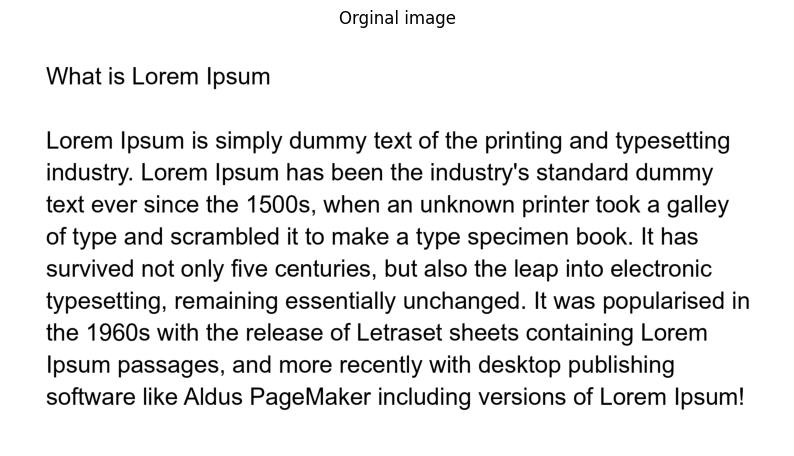


Model tekst:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
survived not only five centuries, but also the leap into electronic
typesetting, remaining essentially unchanged. It was popularised in
the 1960s with the release of Letraset sheets containing Lorem
Ipsum passages, and more recently with desktop publishing
software like Aldus PageMaker including versions of Lorem Ipsum!

Detected text:
What is Lorem Ipsum
Lorem Ipsum is simpIy dummy text of the printing and typesetting
industry. Lorem Ipsum has been the indust'y's standard dummy
text ever since the 1500s, when an unknown printer took a gaIIey
of type and scrambIed it to make a type specimen book. It has
su'vived not onIy five centuries, but aIso the Ieap into eIectronic
typesetting, remaining essentiaIIy

In [72]:
ocr("text1", "arial", 0.96, is_straight=True)

Rozpoznanie znaków osiągnęło ponad 95% poprawności, co świadczy o wysokiej skuteczności. Największe trudności pojawiły się przy odróżnianiu liter **"I"**, **"l"** oraz **"i"**, które w tej czcionce mają bardzo zbliżone kształty. Mimo to wszystkie litery zostały poprawnie wykryte i odpowiednio wyodrębnione z obrazu.

#### Tahoma

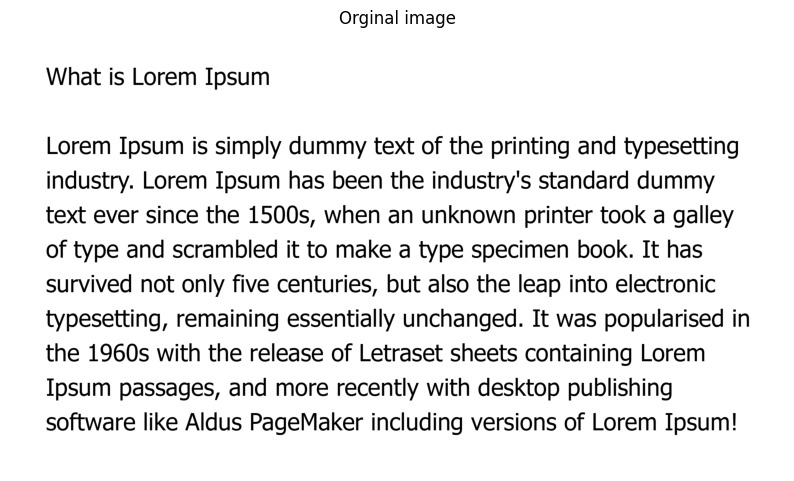


Model tekst:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
survived not only five centuries, but also the leap into electronic
typesetting, remaining essentially unchanged. It was popularised in
the 1960s with the release of Letraset sheets containing Lorem
Ipsum passages, and more recently with desktop publishing
software like Aldus PageMaker including versions of Lorem Ipsum!

Detected text:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text e .er since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
sur. i .ed not only fi .e centuries, but also the leap into electronic
typesetting, remaining essenti

In [73]:
ocr("text1", "tahoma", 0.96, is_straight=True)

Uzyskano aż 98% dokładności rozpoznania tekstu, co stanowi bardzo dobry wynik. W tym przypadku błędy nie polegały na myleniu podobnych liter, takich jak "i" i "l", lecz na pominięciu pojedynczych znaków — na przykład brak litery "v".

### Czcionki szeryfowe

#### latin_modern_roman

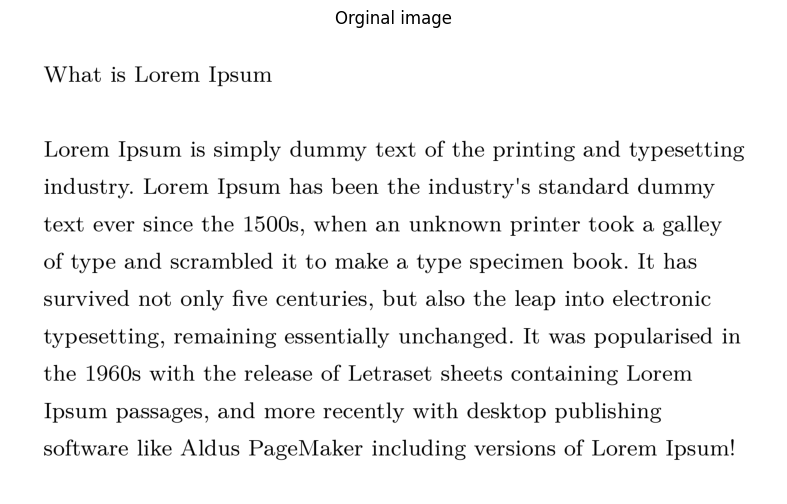


Model tekst:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
survived not only five centuries, but also the leap into electronic
typesetting, remaining essentially unchanged. It was popularised in
the 1960s with the release of Letraset sheets containing Lorem
Ipsum passages, and more recently with desktop publishing
software like Aldus PageMaker including versions of Lorem Ipsum!

Detected text:
What is Lorem Ipsum
Lorem Ipsum is sm'ply dummy text of the prmtmg and typesettmg
mdustry. Lorem Ips''m' has been the mdustry's standard dumm'y
text ever smce the 1500s, when an um nown prmter took a galley
of type and scrambled it to make a type specimen book. It has
s''nvived not only hve cem ''nies, but also the leap mto electromc
typesettmg, remammg essemiahy unchanged

In [74]:
ocr("text1", "latin_modern_roman", 0.94, is_straight=True)

Uzyskana dokładność rozpoznania wyniosła 88,4%, co jest zauważalnie niższym wynikiem w porównaniu do testów z prostszymi czcionkami.

Największe problemy pojawiły się przy literach o podobnych kształtach (np. "i", "l", "m", "n"), a także przy rozpoznawaniu znaków złożonych, takich jak "simply" → "sm'ply", "printing" → "prmtmg" czy "electronic" → "electromc". Charakterystyczne dla tej czcionki szeryfy prawdopodobnie utrudniły modelowi poprawne rozróżnianie znaków.

#### Times New Roman

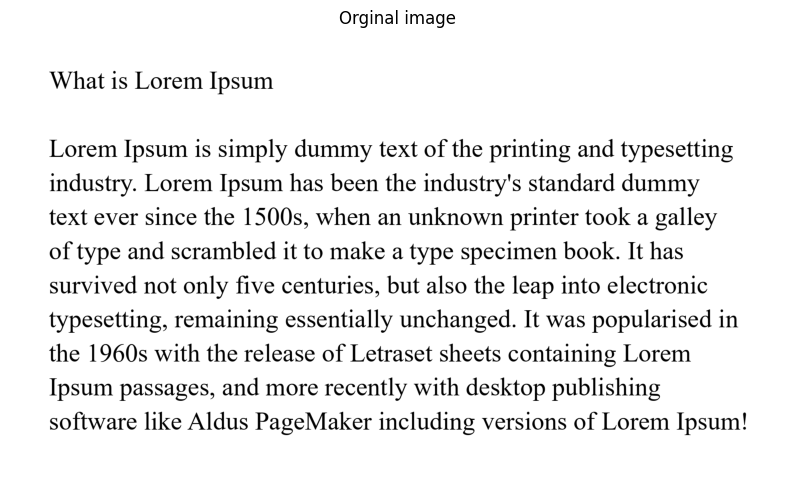


Model tekst:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
survived not only five centuries, but also the leap into electronic
typesetting, remaining essentially unchanged. It was popularised in
the 1960s with the release of Letraset sheets containing Lorem
Ipsum passages, and more recently with desktop publishing
software like Aldus PageMaker including versions of Lorem Ipsum!

Detected text:
Whu is Lorem Ipsum
Lorem Ipsum is simply dummy text ofthe prmtmg and typeseumg
mdusuy. Lorem Ipsum has been the mdusuy's standard du'mmy
text e er smce the l500s, when an um nown prmter took a galley
oftype and scrambled it to make a type specimen book. It has
sur i ed not omy f e centuries, but also the leap mto elecuomc
typeseuing, remaimmg essentially unchanged. It was 

In [75]:
ocr("text1", "times_new_roman", 0.96,  is_straight=True)

Model uzyskał 87,9% dokładności, co wskazuje na wyraźne trudności z rozpoznawaniem tej szeryfowej czcionki. Najczęstsze błędy dotyczyły liter o podobnym kształcie (np. "u" ↔ "n", "v" ↔ "y") oraz łączenia lub pomijania znaków. Mimo tych problemów zachowana została poprawna struktura tekstu, a większość słów została odczytana prawidłowo.

## Text 2

Na obrazie przedstawiono fragment tekstu *Lorem ipsum* z obrotem i bez zaszumienia. 

## Czcionki bezszeryfowe

### Arial

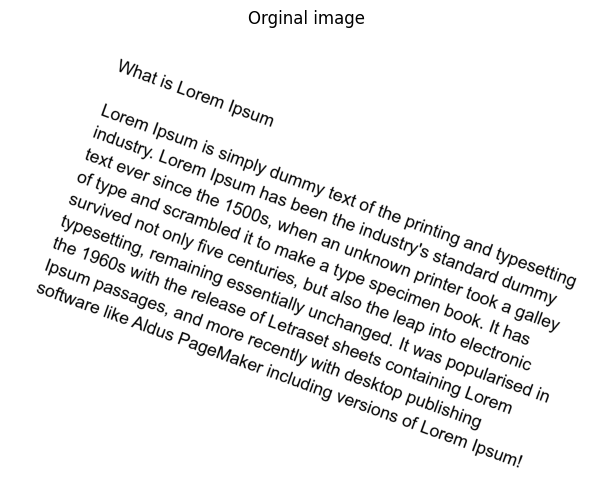

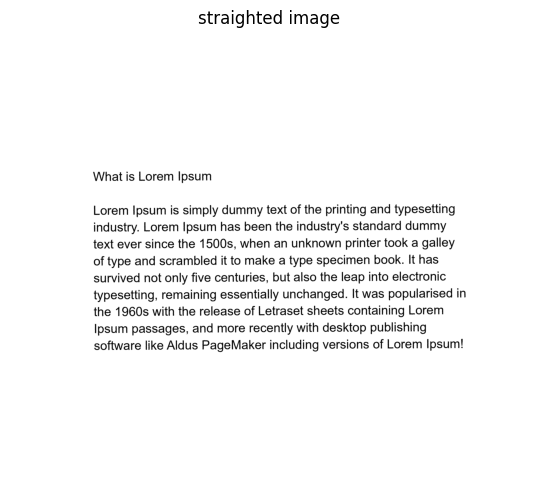


Model tekst:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
survived not only five centuries, but also the leap into electronic
typesetting, remaining essentially unchanged. It was popularised in
the 1960s with the release of Letraset sheets containing Lorem
Ipsum passages, and more recently with desktop publishing
software like Aldus PageMaker including versions of Lorem Ipsum!

Detected text:
What is Lorem Ipsum
Lorem Ipsum is simpIy dummy text of the pnnting and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s when an unknown printer took a gaIIey
of type and scrambIed it to make a type specimen book. It has
survived not onIy five centuries but aIso the Ieap into eIectronic
typesetting, remaining essentiaIIy un

In [76]:
ocr("text2", "arial", 0.9)

Model osiągnął 96,1% dokładności, co jest dobrym wynikiem, choć zauważalny jest niewielki spadek względem tekstu wyprostowanego.

Pogorszenie mogło wynikać z nieidealnego prostowania obrazu po rotacji, co wpłynęło na jakość rozpoznania niektórych liter, zwłaszcza podobnych kształtem (np. "l" i "I"). Mimo to tekst został odczytany bardzo dobrze, co świadczy o odporności modelu na umiarkowaną deformację.

#### Tahoma

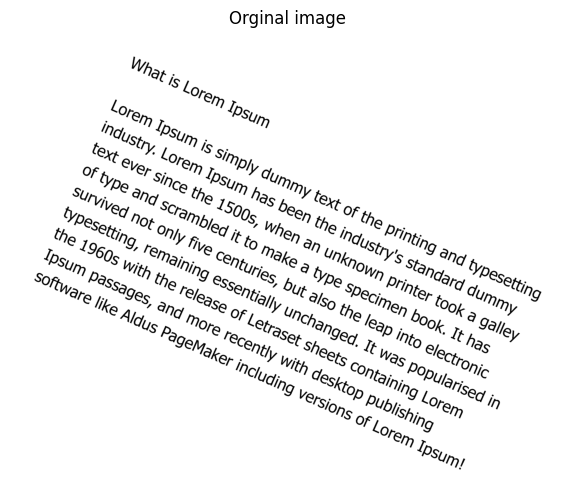

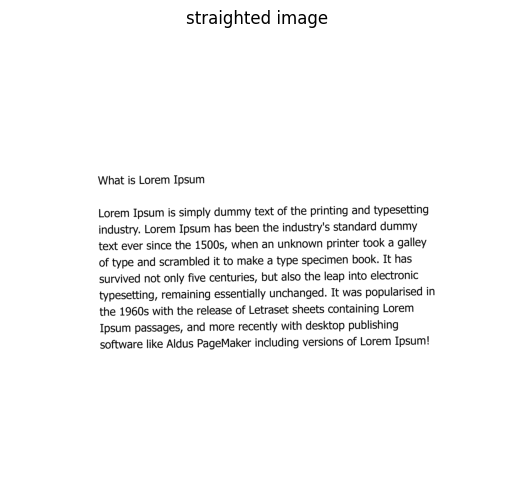


Model tekst:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
survived not only five centuries, but also the leap into electronic
typesetting, remaining essentially unchanged. It was popularised in
the 1960s with the release of Letraset sheets containing Lorem
Ipsum passages, and more recently with desktop publishing
software like Aldus PageMaker including versions of Lorem Ipsum!

Detected text:
What is Lorem Ipsum
Lorem 1psum is simply dummy text of the prinnng and typesehing
indusny. Lorem 1psum has been the indusny's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. 1t has
survived not only nve cenn'''ries, but also the leap into elecnonic
typesehing- , remaining- essennally un

In [77]:
ocr("text2", "tahoma", 0.89)

Model osiągnął 93,7% dokładności, co jest dobrym wynikiem, jednak zauważalne są błędy spowodowane niedokładnym prostowaniem obrazu.

Przekrzywienie wpłynęło na rozpoznanie liter, szczególnie znaków takich jak "I" zamienianych na "1" oraz zniekształcenia w słowach, np. "printing" → "prinnng", "industry" → "indusny". Mimo tych problemów tekst został rozpoznany na wysokim poziomie, co pokazuje względną odporność modelu na niedoskonałości w przetwarzaniu obrazu.

## Czcionki szeryfowe

#### latin_modern_roman

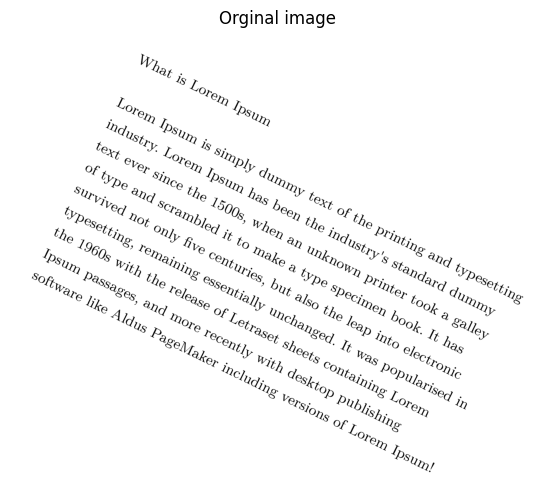

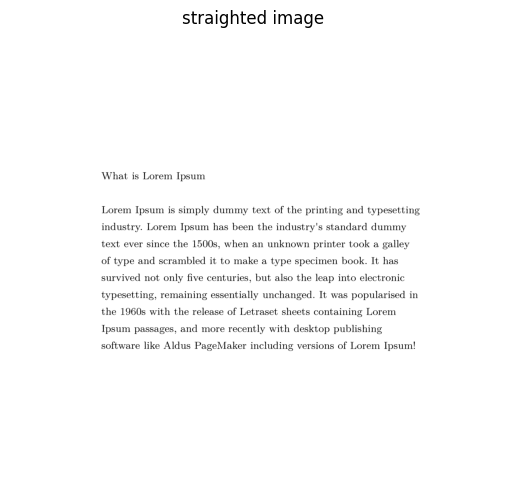


Model tekst:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
survived not only five centuries, but also the leap into electronic
typesetting, remaining essentially unchanged. It was popularised in
the 1960s with the release of Letraset sheets containing Lorem
Ipsum passages, and more recently with desktop publishing
software like Aldus PageMaker including versions of Lorem Ipsum!

Detected text:
What is Lorem Ipsum
Lorem Ipsum is sm''ply dummy text of the prmtmg and typesettmg
mdustry. Lorem Ips''m' has been the mdustry's standard dumm'y
text ever smce the 1500s, when an um.nown primer took a galley
of type and scrambled it to make a type specimen book. It has
smvived not omy nve cemmies. bm also the leap imo electromc
typesettmg, remammg essemiahy ''mcham ed. It 

In [78]:
ocr("text2", "latin_modern_roman", 0.88)

Model uzyskał 85,8% dokładności, co wskazuje na większe trudności z rozpoznaniem tej szeryfowej czcionki, mimo zastosowanego procesu prostowania obrazu.

W porównaniu do wcześniejszych testów na czcionkach bezszeryfowych (Arial, Tahoma), wyniki są niższe, co może wynikać z bardziej skomplikowanych detali i cienkich elementów charakterystycznych dla czcionek szeryfowych.

Błędy polegały głównie na zamianach liter na podobne znaki, pojawianiu się niepożądanych apostrofów i zniekształceniach liter, które utrudniają pełne odczytanie tekstu. Mimo to zachowana została ogólna struktura tekstu i większość słów została poprawnie rozpoznana.

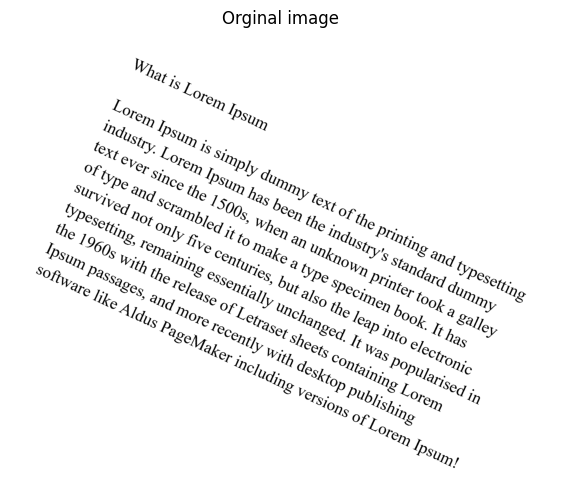

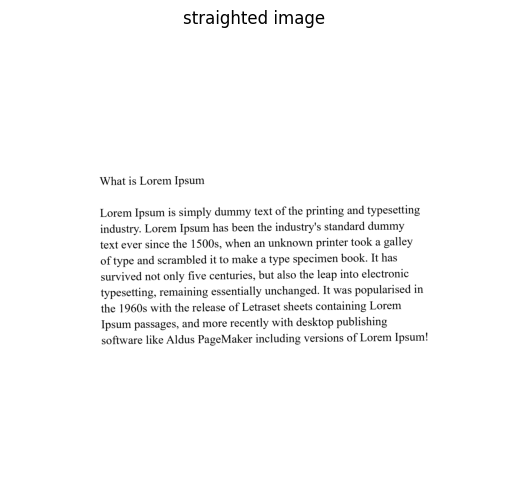


Model tekst:
What is Lorem Ipsum
Lorem Ipsum is simply dummy text of the printing and typesetting
industry. Lorem Ipsum has been the industry's standard dummy
text ever since the 1500s, when an unknown printer took a galley
of type and scrambled it to make a type specimen book. It has
survived not only five centuries, but also the leap into electronic
typesetting, remaining essentially unchanged. It was popularised in
the 1960s with the release of Letraset sheets containing Lorem
Ipsum passages, and more recently with desktop publishing
software like Aldus PageMaker including versions of Lorem Ipsum!

Detected text:
What is Lorem Ipsum
Lorem Ip. sum is simp'y dummy text ofthe prmtmg and typeseumg
mdusuy Lorem Ipsum has been me mdusuy's standard dummy
text e..er smce the '' 500s, when an um.nown prmter took a ga''''ey
oftype and scrambled it to make a type specimen book. It has
sur.i..ed not omy f'... e centuries, but a' o the 'eap mto e''ecuomc
ty. p. eseumg, remaimmg essemia'''y unch

In [79]:
ocr("text2", "times_new_roman", 0.92)

Model osiągnął 80,7% dokładności, co jest wyraźnie niższym wynikiem w porównaniu do wersji bez przekrzywienia. Jest to najgorszy wynik spośród wszystkich testowanych czcionek.

Przekrzywienie znacznie utrudniło rozpoznanie liter, co skutkowało licznymi błędami, w tym wstawianiem niepożądanych znaków i rozdzielaniem słów na fragmenty (np. "Lorem Ipsum" → "Ip. sum"). Wiele liter zostało częściowo rozpoznanych lub zastąpionych znakami podobnymi wizualnie, co obniżyło czytelność tekstu.

Wynik pokazuje, że niedokładne prostowanie obrazu lub duże kąty przekrzywienia znacząco wpływają na jakość rozpoznawania tekstu, zwłaszcza przy czcionkach szeryfowych takich jak Times New Roman.

## Text 3

Na obrazie przedstawiono fragment tekstu dobranego przeze mnie tekstu z obrotem zaszumieniem. 

## Czcionki bezszeryfowe

### Arial

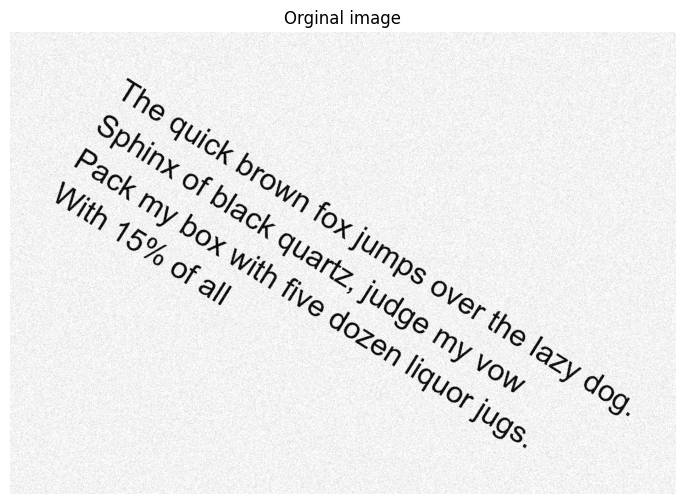

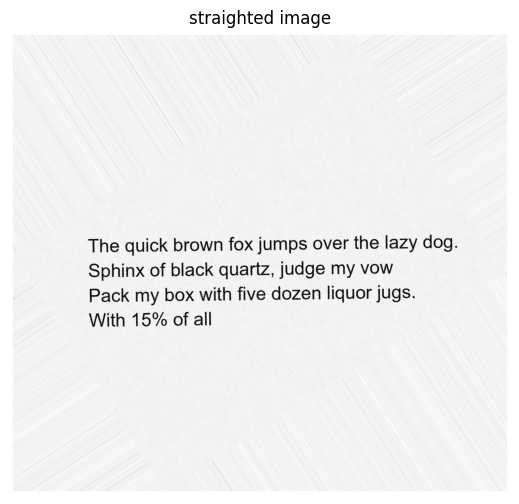


Model tekst:
The quick brown fox jumps over the lazy dog.
Sphinx of black quartz, judge my vow
Pack my box with five dozen liquor jugs.
With 15% of all

Detected text:
The quick brown fox jumps over the Iazy dog.
Sphinx of bIack quanz, judge my vow
Pack my box with five dozen Iiquor jugs.
With 15% of aII

Accuracy: 94.8%


In [80]:
ocr("text3", "arial", 0.85)

Pomimo obecności szumu i przekrzywienia obrazu, model osiągnął 94,8% dokładności, co jest bardzo dobrym wynikiem. Rozpoznanie przebiegło niemal bezbłędnie – pojawiły się jedynie drobne pomyłki, takie jak zamiana liter o podobnym kształcie ("lazy" → "Iazy", "black quartz" → "bIack quanz").

Czcionka Arial, jako bezszeryfowa i dobrze rozdzielona, okazała się odporna na degradację obrazu. Wynik sugeruje, że przy dobrze dobranym kroju pisma model jest w stanie skutecznie radzić sobie z trudnymi warunkami wejściowymi.

Warto zaznaczyć, że prostowanie działa najlepiej właśnie dla tej czcionki

#### Tahoma

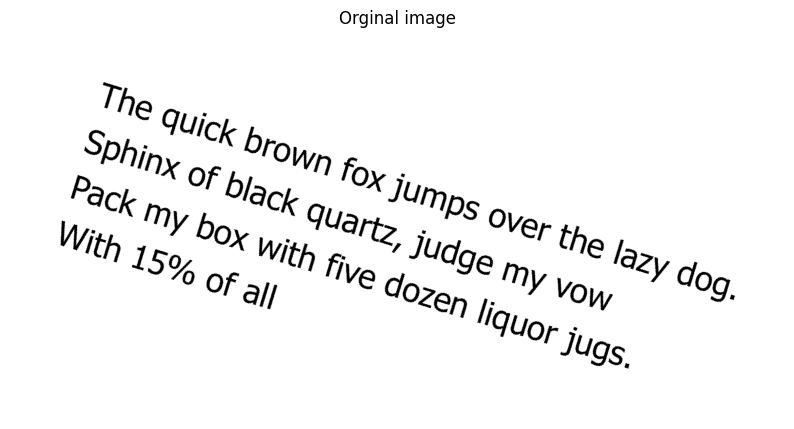

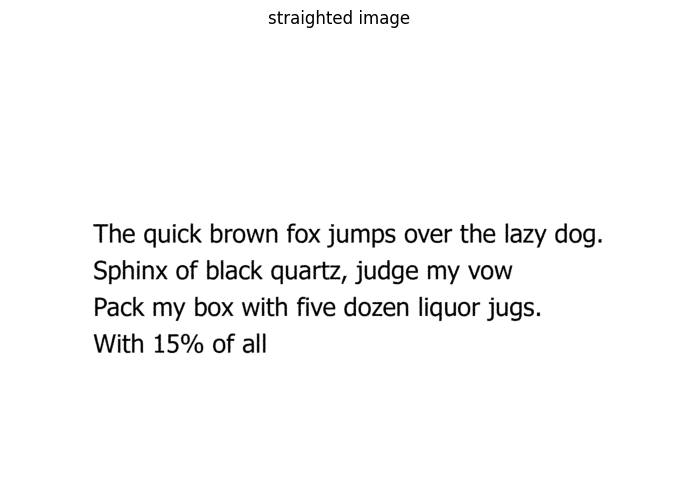


Model tekst:
The quick brown fox jumps over the lazy dog.
Sphinx of black quartz, judge my vow
Pack my box with five dozen liquor jugs.
With 15% of all

Detected text:
The quick brown fox jumps over the lazy dog.
Sphinx of black quartz, judge my vow
Pack my box with five dozen liquor jugs.
With 15% of all

Accuracy: 100.0%


In [81]:
ocr("text3", "tahoma", 0.90)

Mimo początkowego zaszumienia i przekrzywienia, po przekształceniu obraz został prawidłowo wyprostowany, co umożliwiło osiągnięcie 100% dokładności.

Czcionka Tahoma (bezszeryfowa, o dużym odstępie między znakami) okazała się wyjątkowo odporna na zakłócenia i bardzo dobrze współpracuje z procesem prostowania. To pokazuje, że przy odpowiednim przygotowaniu obrazu i dobrze dobranym kroju pisma można uzyskać bezbłędne rozpoznanie nawet w trudniejszych warunkach.

### Czcionki szeryfowe

#### latin_modern_roman

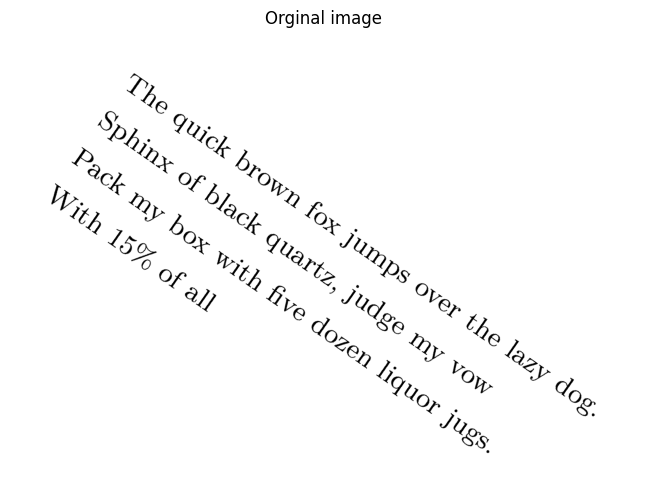

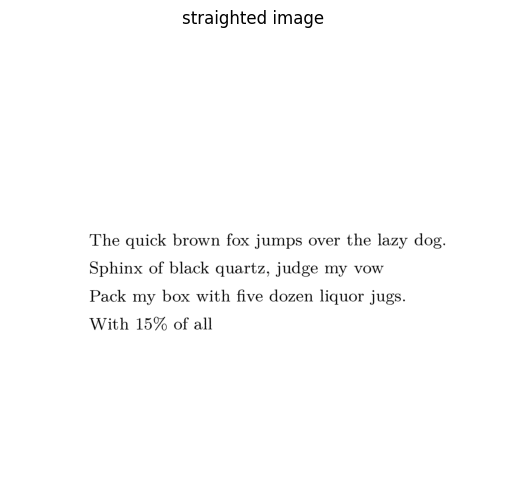


Model tekst:
The quick brown fox jumps over the lazy dog.
Sphinx of black quartz, judge my vow
Pack my box with five dozen liquor jugs.
With 15% of all

Detected text:
The quick brown fox jumps over the lazy dog
Spmmx of black quartz. judge my vow
Pack my box wuh hve dozen liquor jugs.
With 15% of ah

Accuracy: 91.9%


In [82]:
ocr("text3", "latin_modern_roman", 0.9)

Pomimo przeprowadzenia prostowania obrazu, dokładność rozpoznania wyniosła 91,9%, co jest zauważalnie niższym wynikiem w porównaniu do czcionek bezszeryfowych testowanych na tym samym materiale.

Czcionka Latin Modern Roman jako szeryfowa, o cieńszych i bardziej zróżnicowanych kształtach liter, okazała się trudniejsza do jednoznacznego odczytu w warunkach zakłóceń i zniekształceń. Szczególne problemy pojawiły się przy rozpoznawaniu liter „Sphinx” → „Spmmx” czy „with” → „wuh”.

Wniosek: mimo prostowania, czcionki szeryfowe są bardziej podatne na błędy w OCR w obecności szumu i przekrzywienia obrazu niż czcionki bezszeryfowe jak Tahoma czy Arial.

#### Times New Roman

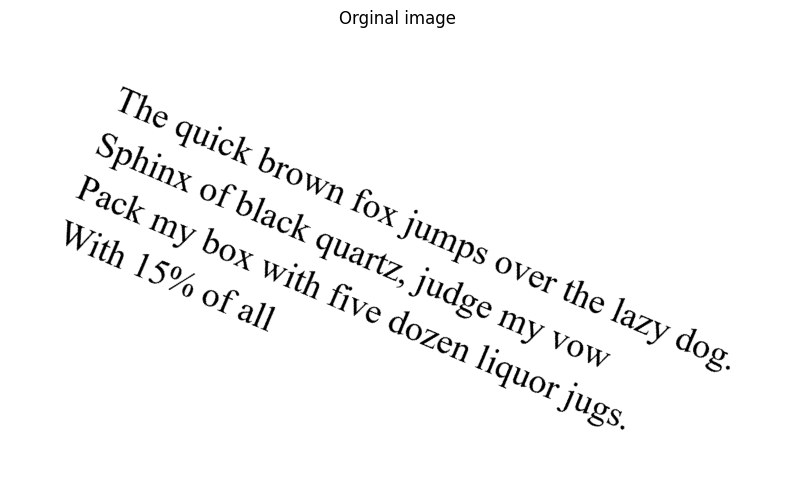

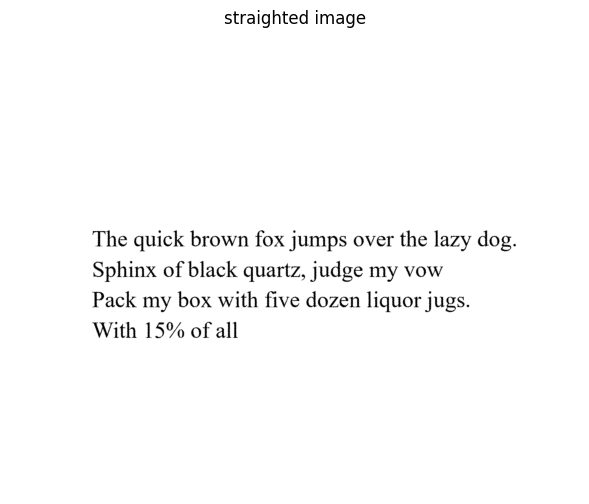


Model tekst:
The quick brown fox jumps over the lazy dog.
Sphinx of black quartz, judge my vow
Pack my box with five dozen liquor jugs.
With 15% of all

Detected text:
The quuck brown fox jumps over me lazy dog.
Spmmx ofblack qu.utz, judge my vow
Pack my box wim five dozen liquorjugs.
Wim l5% of all

Accuracy: 88.9%


In [83]:
ocr("text3", "times_new_roman", 0.88, space_size=10)

Pomimo zastosowania prostowania, detekcja tekstu w czcionce **Times New Roman** osiągnęła dokładność **88,9%**, co jest **niższe niż w przypadku Latin Modern Roman (91,9%)**, a znacząco niższe niż w przypadku bezszeryfowych czcionek (np. Tahoma – 100%).

#### Typowe błędy:

* **Literówki z winy szumu i kształtu liter:**

  * „The **quuck** brown…” zamiast „quick”
  * „over **me** lazy dog” zamiast „the”
  * „Spmmx” zamiast „Sphinx”
  * „qu.utz” zamiast „quartz”
* **Problemy z rozdzielaniem słów i interpunkcją**, np.:

  * „ofblack” zamiast „of black”
  * „liquorjugs.” bez spacji


# Podsumowanie

## Skuteczność OCR dla różnych czcionek:

1. **Czcionki bezszeryfowe**:
   - Arial: 94-96% dokładności, stabilne wyniki nawet przy zakłóceniach
   - Tahoma: 89-100% dokładności, ale problemy z prostowaniem obrazu
   - Głównie problemy z rozróżnianiem podobnych znaków (I, l, 1)
   - Lepsze wyniki ogólne dzięki prostszej konstrukcji znaków

2. **Czcionki szeryfowe**:
   - Latin Modern Roman: 85-92% dokładności
   - Times New Roman: 80-89% dokładności
   - Częste problemy z interpretacją szeryfów jako osobnych znaków
   - Niższa skuteczność ze względu na złożoność kształtów

## Problemy specyficzne dla czcionek:

1. **Arial**:
   - Mylenie podobnych znaków (I, l, i)
   - Dobra odporność na szum i rotację
   - Najlepsza skuteczność prostowania obrazu

2. **Tahoma**:
   - Problemy z niewykrywaniem niektórych znaków (np. "v")
   - Nieefektywne prostowanie obrazu
   - Dobre wyniki przy idealnym wyprostowaniu

3. **Latin Modern Roman**:
   - Błędna interpretacja złożonych liter ("m" → "rn")
   - Dodawanie niepotrzebnych apostrofów ("simply" → "sm'ply")
   - Problemy z rozpoznawaniem szeryfów

4. **Times New Roman**:
   - Najsłabsze wyniki ze wszystkich czcionek
   - Znaczące problemy z prostowaniem obrazu
   - Częste łączenie lub dzielenie słów
   - Mylenie podobnych znaków (u/n, v/y)

## Wnioski dotyczące algorytmu:

1. **Prostowanie obrazu**:
   - Niewystarczająca skuteczność dla Tahomy i Times New Roman
   - Najlepsze wyniki dla Arial
   - Wymaga udoskonalenia dla czcionek szeryfowych

2. **Wpływ zakłóceń**:
   - Szum ma mniejszy wpływ niż przekrzywienie
   - Czcionki bezszeryfowe są bardziej odporne na zakłócenia
   - Przekrzywienie znacząco pogarsza wyniki dla czcionek szeryfowych